In [178]:
from surprise import SVD, KNNBasic, NMF
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np

In [179]:
plt.rcParams['figure.figsize'] = [20, 4]

from surprise import Dataset

data = Dataset.load_builtin('ml-100k')

# show the first five data points
# user_id   item_id	rating	timestamp


for i in range (len(data.raw_ratings)):
    # print(data.raw_ratings[i][0])
    if (data.raw_ratings[i][0] == '871' and data.raw_ratings[i][1] == '681'):
        rating = data.raw_ratings[i][2]
    
# print(data.raw_ratings[0][0])
rating

1

In [180]:
trainset, testset = train_test_split(data, test_size=0.25)

# Decide the best algorithm for the dataset

In [181]:


# Load the ml-100k dataset
data = Dataset.load_builtin('ml-100k')

# Define the evaluation metric (in this case, RMSE)
sim_options = {'name': 'cosine', 'user_based': True}

# Define the algorithms to compare
algorithms = [SVD(), KNNBasic(sim_options=sim_options), NMF()]

# Evaluate the algorithms using cross-validation
for algorithm in algorithms:
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    print(f"{algorithm.__class__.__name__}: Average RMSE = {sum(results['test_rmse'])/len(results['test_rmse'])}")

# Lowest RMSE is for SVD

SVD: Average RMSE = 0.9370737991772604
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNBasic: Average RMSE = 1.0168939265501797
NMF: Average RMSE = 0.9644246689240112


# Grid search for the best SVD parameters

In [182]:
# Define the parameter grid for the SVD algorithm
param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008], 'reg_all': [0.08, 0.1, 0.15]}

# Define the grid search object and fit it on the dataset
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# Print the best RMSE and MAE scores, along with the corresponding hyperparameters
print(f"Best RMSE score: {gs.best_score['rmse']:.3f}")
print(f"Best MAE score: {gs.best_score['mae']:.3f}")
print(f"Best hyperparameters: {gs.best_params['rmse']}")


Best RMSE score: 0.927
Best MAE score: 0.733
Best hyperparameters: {'n_factors': 40, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.08}


In [183]:
factors = gs.best_params['rmse']['n_factors']
epochs = gs.best_params['rmse']['n_epochs']
lr_value = gs.best_params['rmse']['lr_all']
reg_value = gs.best_params['rmse']['reg_all']

algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

In [184]:
# Generate predictions for the testing set
predictions = algo.test(testset)

# Calculate and print the RMSE and MAE of the predictions
print(f"RMSE: {accuracy.rmse(predictions)}")
print(f"MAE: {accuracy.mae(predictions)}")

RMSE: 0.9262
RMSE: 0.9262211188326062
MAE:  0.7338
MAE: 0.7338141297736438


In [185]:
def get_num_user_ratings(uid):
    """ 
    args: 
      uid: user id
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_num_item_ratings(iid):
    """ 
    args:
      iid: the item id
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_num_user_ratings)
df_predictions['Ui'] = df_predictions.iid.apply(get_num_item_ratings)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)
df_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,624,150,4.0,4.029860,{'was_impossible': False},97,122,0.029860
1,253,12,5.0,4.479109,{'was_impossible': False},61,205,0.520891
2,903,81,5.0,3.940375,{'was_impossible': False},98,83,1.059625
3,125,996,3.0,2.418446,{'was_impossible': False},134,10,0.581554
4,7,601,5.0,4.276075,{'was_impossible': False},296,16,0.723925


In [186]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [187]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
10422,928,496,5.0,5.0,{'was_impossible': False},21,177,0.0
980,181,948,1.0,1.0,{'was_impossible': False},309,37,0.0
7561,181,826,1.0,1.0,{'was_impossible': False},309,58,0.0
19568,405,564,1.0,1.0,{'was_impossible': False},556,18,0.0
1457,270,98,5.0,5.0,{'was_impossible': False},105,298,0.0
5521,507,50,5.0,5.0,{'was_impossible': False},44,433,0.0
21736,181,688,1.0,1.0,{'was_impossible': False},309,28,0.0
17600,849,633,5.0,5.0,{'was_impossible': False},17,45,0.0
9446,907,427,5.0,5.0,{'was_impossible': False},109,163,0.0
4111,928,172,5.0,5.0,{'was_impossible': False},21,263,0.0


In [188]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
5698,167,169,1.0,4.320054,{'was_impossible': False},51,96,3.320054
5845,97,192,1.0,4.361425,{'was_impossible': False},44,90,3.361425
23937,434,7,1.0,4.375573,{'was_impossible': False},27,295,3.375573
3894,272,133,1.0,4.439876,{'was_impossible': False},34,120,3.439876
2608,434,628,1.0,4.447878,{'was_impossible': False},27,124,3.447878
22006,434,9,1.0,4.471216,{'was_impossible': False},27,228,3.471216
24690,127,690,1.0,4.532587,{'was_impossible': False},16,105,3.532587
24191,246,56,1.0,4.579032,{'was_impossible': False},148,287,3.579032
6413,295,96,1.0,4.598881,{'was_impossible': False},153,206,3.598881
19874,270,237,1.0,4.658860,{'was_impossible': False},105,289,3.658860


In [189]:
print(predictions[0])

user: 624        item: 150        r_ui = 4.00   est = 4.03   {'was_impossible': False}


# Precision and recall


In [190]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    

results

[{'K': 2, 'Precision': 0.9447983014861996, 'Recall': 0.19487223917698376},
 {'K': 3, 'Precision': 0.9368365180467074, 'Recall': 0.27906362642719346},
 {'K': 4, 'Precision': 0.929051663128096, 'Recall': 0.35444684526306436},
 {'K': 5, 'Precision': 0.9231068648266076, 'Recall': 0.4194680225678055},
 {'K': 6, 'Precision': 0.91924982307148, 'Recall': 0.47721015590161325},
 {'K': 7, 'Precision': 0.9130067738347992, 'Recall': 0.524238361736732},
 {'K': 8, 'Precision': 0.906959609746234, 'Recall': 0.562256235153087},
 {'K': 9, 'Precision': 0.9045120985407646, 'Recall': 0.5974285948560175},
 {'K': 10, 'Precision': 0.900301199743873, 'Recall': 0.6260243394100613}]

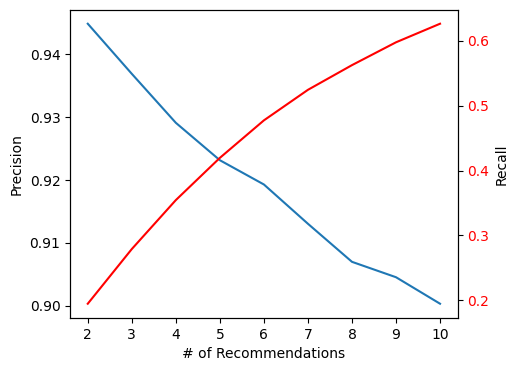

In [193]:
plt.rcParams['figure.figsize'] = [5, 4]

Rec=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')
    ###



# Recommend movies!

In [197]:
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

In [198]:
def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n



all_pred = get_all_predictions(predictions)


In [199]:
#To get top 5 reommendation
n = 5

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]



In [212]:
tmp = pd.DataFrame.from_dict(all_pred)
tmp_transpose = tmp.transpose()

In [206]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results

In [213]:
user_id='67'
results = get_predictions(user_id)
results


0                    (408, 5)
1                   (1449, 5)
2    (169, 4.993548968840317)
3    (318, 4.916319314778127)
4    (483, 4.909862552026114)
Name: 67, dtype: object

In [240]:
recommended_movie_ids=[]
for x in range(0, n):
    recommended_movie_ids.append(results[x][0])

recommended_movie_ids = [eval(i) for i in recommended_movie_ids] # cast to int 

recommended_movie_ids

[408, 1449, 169, 318, 483]

In [242]:
movies = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin-1')
# print(movies[0][:])

recommended_movies = movies[movies[0][:].isin(recommended_movie_ids)]
recommended_movies

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
168,169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
317,318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
407,408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
482,483,Casablanca (1942),01-Jan-1942,NaN,http://us.imdb.com/M/title-exact?Casablanca%20...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1448,1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [243]:
ratings = pd.read_csv('data/ratings.csv')


ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/ratings.csv'